In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy import stats
from scipy.special import inv_boxcox

## granger test

In [67]:
#On crée la fonction pour tester les corr respectives pour modèle VAR
def grangers_test(data, lag, test='ssr_chi2test',verbose=False):    
    """Les valeurs dans le df sont les p-valeurs
    L'hypothèse H0 de notre test est la suivant :
        "Les prédictions de la série X n'influence pas les prédictions de la série Y"
    Ce qui signifie qu'une p-valeur inférieure à 0.05 rejette l'hypothèse H0 et incite à garder ce couple de valeurs
    Comme on s'intéresse à la prédiciton de la variable 1, on ne va jamais l'abandonner

Les arguments sont :
    Data, le DF de nos valeurs
    maxlag, le fameux maxlag pour le nombre de paramètres dans l'équation'
    variables : une list qui contient le nom des variables c'est à dire le nom de nos colonnes'
    """
    df = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=[lag], verbose=False)
            p_values = round(test_result[lag][0][test][1],4) #on va avoir toutes les p-valeurs une part lag
            p_value = np.min(p_values) #On s'intéresse à la valeur minimale des p-valeur
            df.loc[row, col] = p_value
    df.columns = [var for var in data.columns]
    df.index = [var + '_Y' for var in data.columns]
    return df

#Fonction test stationarité
def dickey_fuller_test(data, seuil_signif=0.05, name='', verbose=False):
    """On conduit un test de Dick-Fuller sur notre data set et on imprime les résultats"""
    """On rappelle que pour rejeter l'hypothèse H0 il faut que la p-value soit inférieur au seuil choisi, ici 0.05"""
    result = adfuller(data, autolag='BIC')
    output = {'statistique_du_test':round(result[0], 4), 'p_value':round(result[1], 4), 'n_lags':round(result[2], 4), 'n_obs':result[3]}
    p_value = output['p_value'] 

    # Print Summary
    print(f'    Test de Dick-Fuller augmenté sur : "{name}"', "\n   ", '~'*47)
    print(f' Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.')
    print(f' La p-value est de      : {p_value}')
    print(f' Niveau de confiance    = {seuil_signif}')
    print(f' Statistique de test    = {output["statistique_du_test"]}')
    print(f' Nombre de lags choisis = {output["n_lags"]}')

    if p_value <= seuil_signif:
        print(f" => P-Value = {p_value} <= {seuil_signif}. On rejette H0 au seuil de confiance.")
        print(f" => La série est STATIONNAIRE.")
    else:
        print(f" => P-Value = {p_value} > {seuil_signif}. On ne peut pas rejeter H0 au seuil de confiance.")
        print(f" => La série est NON stationnaire.")

## box cox test on features

In [68]:
def box_cox_test(dataframe_to_test):
    """We will test for each variable if a BoxCox transform brings us more normality

    Args:
        dataframe_to_test (dataframe): the dataframe that holds our data
    """
    list_non_transformed = []
    list_box_cox = []
    for col in dataframe_to_test:
        data = dataframe_to_test[col]
        if (data < 0).values.any():
            list_non_transformed.append(col)
            continue
        fig = plt.figure()
        ax1 = fig.add_subplot(221)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(222)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

        # normality test
        stat, p = stats.normaltest(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

        xt, _ = stats.boxcox(data)
        if not np.isfinite(xt).any():
            list_non_transformed.append(col)
            continue
        list_box_cox.append(col)
        
        ax2 = fig.add_subplot(223)
        prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
        ax2.set_title('Probplot after Box-Cox transformation')
        ax22 = fig.add_subplot(224)
        ax22.hist(xt)
        ax22.set_xlabel(col)
        ax22.set_title('distplot')

        stat, p = stats.normaltest(xt)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
        
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.4)
        plt.show()
    print('*'*50 +'\n' +'*'*50)
    print(f"Les données suivantes n'ont pas pu être scaled (négatives, infinites) : {list_non_transformed}. \n Voici leur plot non transformé")
    for col in list_non_transformed:
        data = dataframe_to_test[col]
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(212)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

    return list_box_cox, list_non_transformed

## reduction of dataset thanks to granger test

In [69]:
#function to reduce dim thanks to granger test
def reduce_dim_granger_test(df_to_reduce, lag_to_apply):
    """We reduce the dataset thanks to the granger test 
        We test that every variables in the dataframe are usefull to predict each other, and if not, we drop them
        After each iteration of "features optimization", we run again the model fit in order to verify that the best lag_order has not changed.
        If it as, we run the granger test optimization again
    Args:
        df_to_reduce (_type_): the data frame we want to reduce
        lag_to_apply (_type_): the current lag order of the model we use in that precise iteration 

    Returns:
        _type_: we return the dataframr that has been reduced
    """
    df_granger = grangers_test(df_to_reduce, lag = lag_to_apply)
    np.fill_diagonal(df_granger.values, 0)
    #plt.figure(figsize = (16,5))
    #sns.heatmap(df_granger, annot = True)
    #plt.show()
    while (df_granger.values>= 0.05).any():
        list_feature_non_granger_causal = []
        list_value_non_granger_causal = []
        for col in df_granger.columns:
            if (df_granger[col].values >= 0.05).any() and col != 'nd':
                list_feature_non_granger_causal.append(col)
                list_value_non_granger_causal.append(sum(df_granger[col].values))
        df_feature_to_pop = pd.DataFrame(list_value_non_granger_causal, index = list_feature_non_granger_causal, columns=['p-value'])  
        df_to_reduce = df_to_reduce.drop(df_feature_to_pop['p-value'].idxmax(), axis = 1)
        df_granger = grangers_test(df_to_reduce, lag = 5)
        np.fill_diagonal(df_granger.values, 0)
        #plt.figure(figsize = (16,5))
        #sns.heatmap(df_granger, annot = True)

    return df_to_reduce

In [70]:
#transform boxcox on selected variables
def transfo_boxcox(dataframe_to_transform, list_features_to_transform):
    dict_lambda = {}
    transformed = dataframe_to_transform.copy()
    for ft in list_features_to_transform:
        transformed[ft], l = stats.boxcox(dataframe_to_transform[ft])
        dict_lambda[ft] = l
    return transformed, dict_lambda

## convergence lag features

In [71]:
def convergence_lag_features(initial_dataframe, exog, maxlag_to_converge, n_period):
    """_summary_

    Args:
        initial_dataframe (pandas Dataframe): The initial dataframe you want to perform the convergence on. It is the dataframe you want the data
        to be trained on, so it must be transformed, differenciated if needed...
        exog (pandas dataframe): the exogeneous features you give to your model. Must be known for train and test ! Good example is holidays, 
        Fourier features...
        maxlag_to_converge (int): the maximum number of lags to include in your model. The code will test them all so the bigger the longer 
        the training time ! Be careful as it is exponential UwU
        n_period (int): number of time periods (days, hours...) you want to predict

    Returns:
    model (statsmodel model in that cas) : the fitted model 
    training_set (pandas dataframe) : the training set being granger tested
    training_set_exog (pandas dataframe) : the training set being granger tested
    test_set (pandas dataframe) : the test set being granger tested
    test_set_exog (pandas dataframe) : the training set exog
    df_diff (pandas dataframe) :  the test set exog 
    result_normality (float) : the results of the normality test on resisdual. If not normal, confidence intervals might
    be unreliable
    result_whiteness (flaot) : the result of the whiteness of residuals.
    """

    df_diff = initial_dataframe.copy()
    training_set=df_diff[:-n_period]
    training_set_exog = exog[:-n_period]
    testing_set = df_diff[-n_period:]
    test_set_exog = exog[-n_period:]
    
    model = VAR(endog = training_set, exog = training_set_exog)
    print(maxlag_to_converge)

    print(model)
    model = model.fit(maxlags=maxlag_to_converge, ic = "aic")

    lag_start = model.k_ar
    lag_second = None 
    print(model.k_ar)
    while lag_start != lag_second:
        if lag_second:
            print(f"lag actuel égal {lag_second}")
            df_diff_2= reduce_dim_granger_test(df_diff, lag_second)
        else:
            print(f"lag actuel égal {lag_start}")
            df_diff_2= reduce_dim_granger_test(df_diff, lag_start)
        if df_diff_2.equals(df_diff):
            print("Dataframe passed the granger test without changes. Break")
            break
        df_diff = df_diff_2.copy()
        print(f"Colonnes gardées = {df_diff.columns}")
        training_set = df_diff[:-n_period]
        testing_set= df_diff[-n_period:]

        model = VAR(endog = training_set, exog = training_set_exog)
        model = model.fit(maxlags=maxlag_to_converge, ic = "aic")
        result_normality = model.test_normality().pvalue #"H0 : les données suivent une loi normale. Si p-value <0.05, on rejette
        result_whiteness = model.test_whiteness(round((len(training_set) + len(testing_set))/5)).pvalue
        lag_second = model.k_ar
        print(f"le lag après l'opti de granger puis reopti model est de {lag_second}")

    print(f"Le lag final est de {model.k_ar}")
    print(f"Les features finales sont {df_diff.columns}")
    return model, training_set, training_set_exog, testing_set, test_set_exog, df_diff, result_normality, result_whiteness

## r2_ajusted

In [72]:
def r2_ajusted(r2, df):
    longueur = len(df.index)
    nb_col = len(df.columns)
    score_ajusted = 1-((1-r2)*(longueur-1) / (longueur - nb_col -1))
    return score_ajusted

In [73]:
#Fonction plotting historique, True, Pred
def plot_pred_true(y_pred, y_true):
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_du_split, y_true, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("resultat.png")

def plot_pred_true_total(y_pred, y_true):
    date_list = df.index.tolist() + date_du_split.tolist()
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_totale, variable_cible, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("Historique et true VS prédiction.png")

## inverting the diff

In [74]:
#pour detransfo data :
def inv_diff(df_train, df_forecast, n_jour_cible, second_diff = False):
    df_fc_inv = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        """
        Attention ! lorsque l'on inverse une différenciation, un récupère la "dernière donnée" à laquelle on rajoute
        la somme cumulée des valeurs différenciées.
        Dans le cas d'un array prédit, le dernier point de donnée n'est PAS le "-1" du train_set, mais le "-1-nb_jour_pred"
        Dans notre cas on va donc retourner 120 jours en arrière
        Dans le cas d'une double diff, on soustrait d'abord l'avant dernière valeur à la dernière
        """
        if second_diff:
            df_fc_inv[str(col)+'_1d'] = (df_train[col].iloc[-n_jour_cible-1]-df_train[col].iloc[-n_jour_cible-2]) + df_fc_inv[str(col)].cumsum()
            df_fc_inv[str(col)+'_forecast'] = df_train[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)+"_1d"].cumsum()
        else:
            df_fc_inv[col] = df_train[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)].cumsum()
    return df_fc_inv

# I. Data loading & quick prep

## a. Loading

In [75]:
df = pd.read_csv("C:/Users/vdistefano/Desktop/projet_dev_perso/Article_VAR_FR_Public/historic_demand_2009_2023_noNaN.csv")
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.set_index('settlement_date')
df = df.drop(['settlement_period', 'period_hour'], axis = 1)
exog = df[['is_holiday']].copy()
df = df.drop(['is_holiday'], axis =1)

## b. Parameters

In [76]:
target_variable = "tsd"
index_df = df.index
n_period_predict = 48 * 7

## c. Prep/Cleaning

In [77]:
mask = (df.index > '2022-01-01')
df_pour_var = df.loc[mask]
exog_pour_var = exog.loc[mask]
df_pour_var = df_pour_var +1

In [78]:
initial_training_set=df_pour_var[:-n_period_predict]
initial_training_set_exog = exog_pour_var[:-n_period_predict]
initial_testing_set = df_pour_var[-n_period_predict:]
initial_test_set_exog = exog_pour_var[-n_period_predict:]

In [79]:
for name, column in df_pour_var.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0322
 Niveau de confiance    = 0.05
 Statistique de test    = -3.0298
 Nombre de lags choisis = 45
 => P-Value = 0.0322 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0063
 Niveau de confiance    = 0.05
 Statistique de test    = -3.5707
 Nombre de lags choisis = 45
 => P-Value = 0.0063 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est No

In [80]:
df_diff_1 = df_pour_var.diff().dropna()
exog_pour_var = exog_pour_var[1:]
for name, column in df_diff_1.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -27.2299
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -32.6588
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationn

## d. BoxCox transformation ?

**************************************************
**************************************************
Les données suivantes n'ont pas pu être scaled (négatives, infinites) : ['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow']. 
 Voici leur plot non transformé


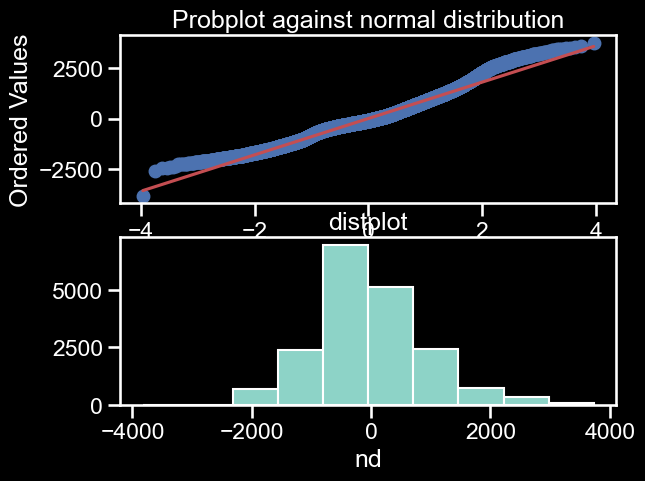

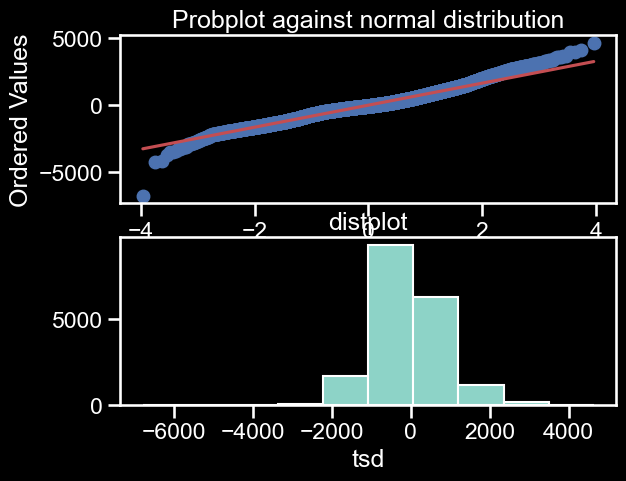

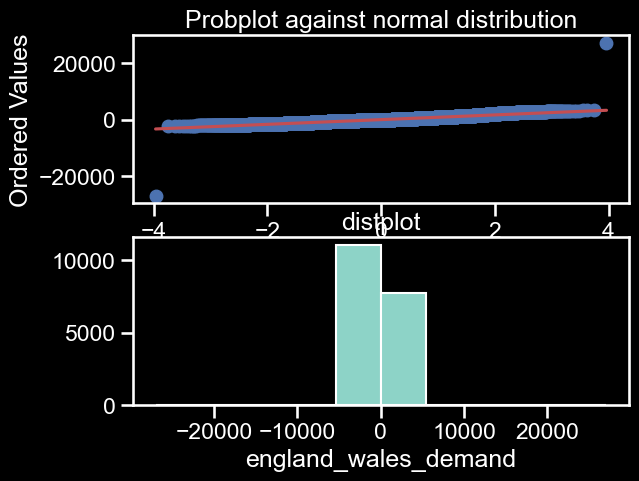

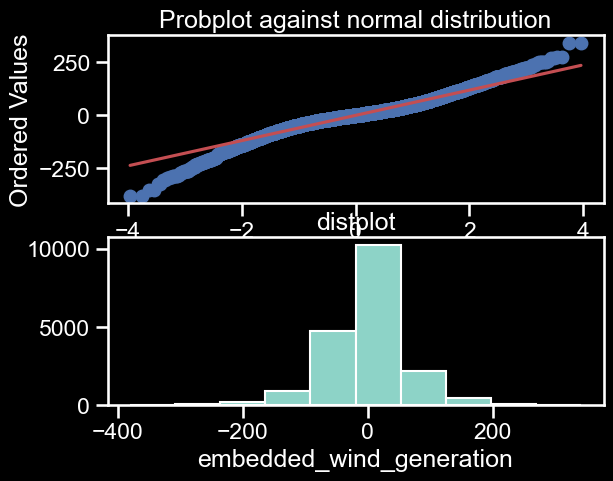

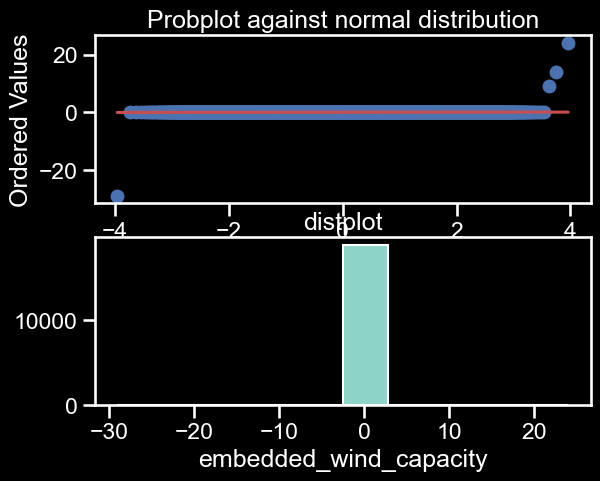

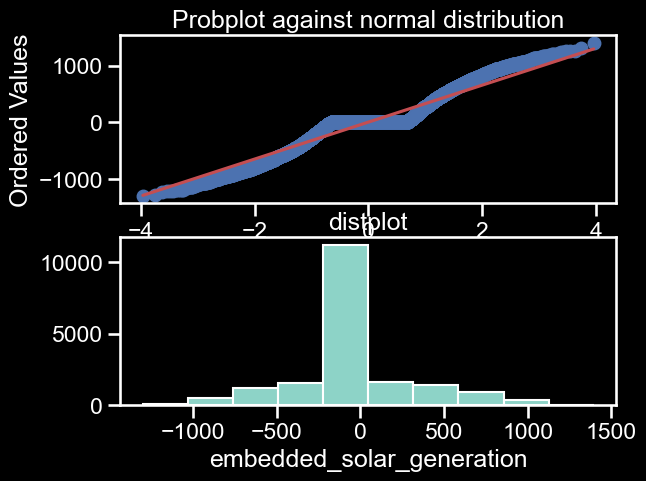

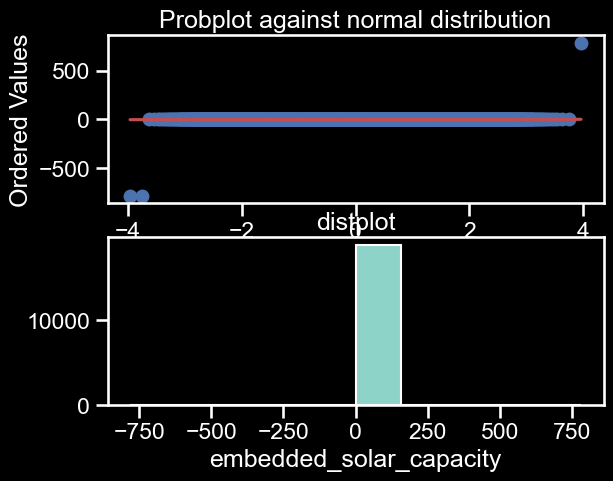

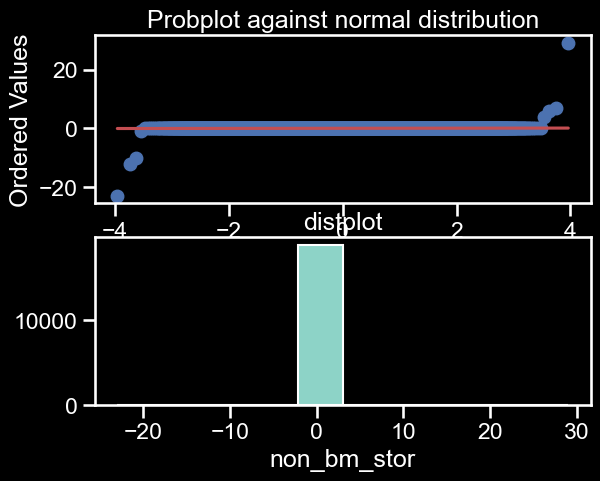

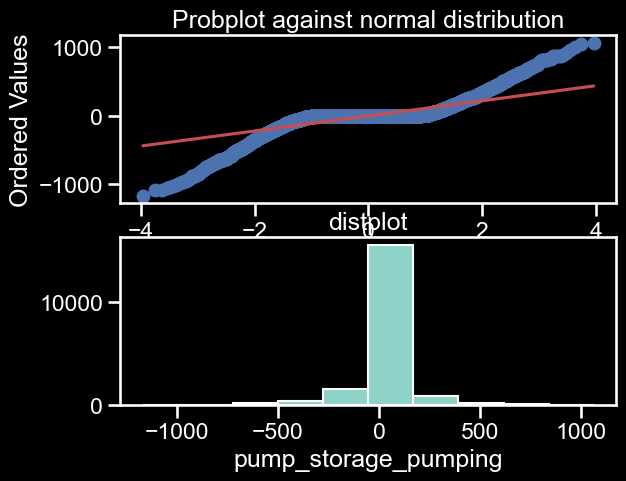

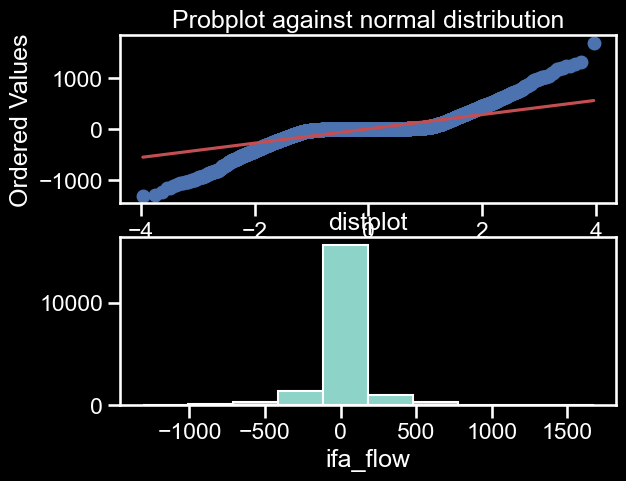

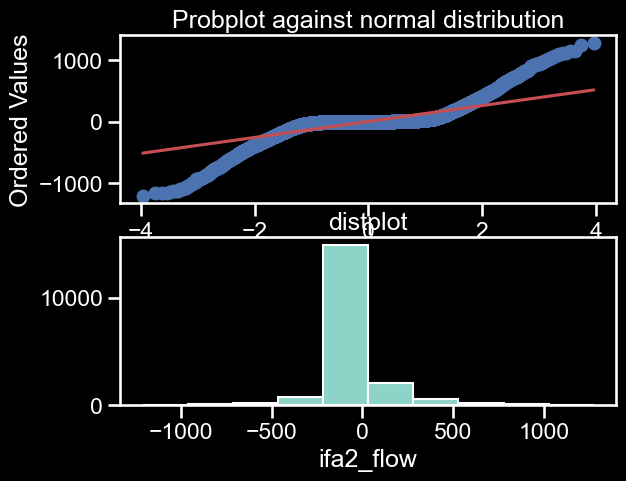

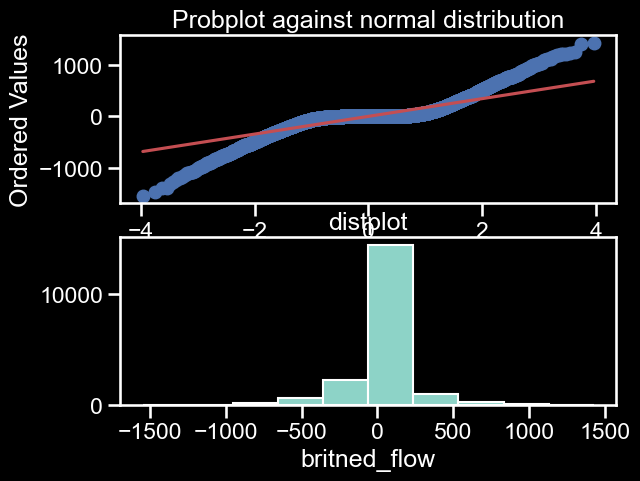

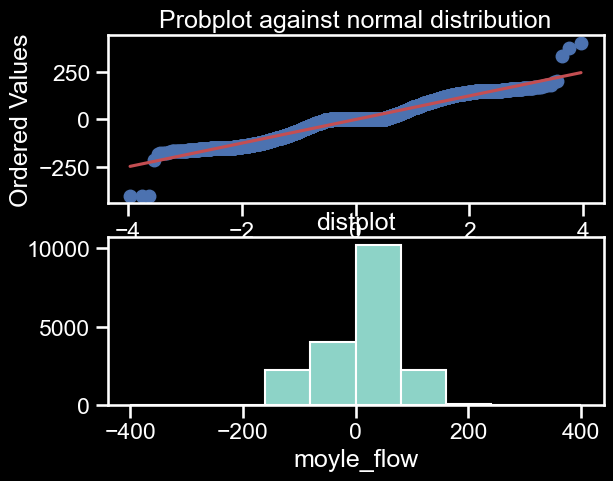

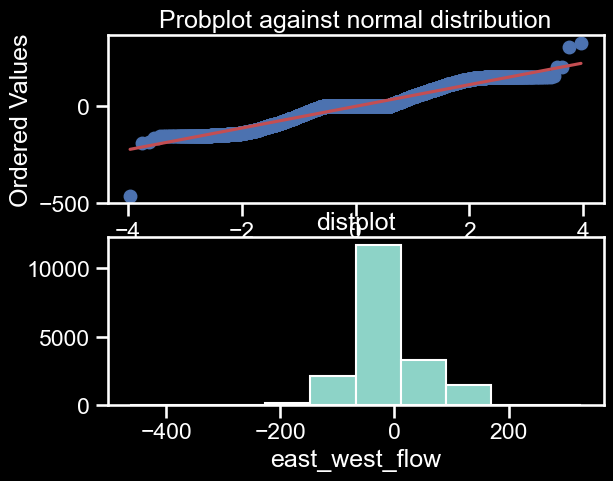

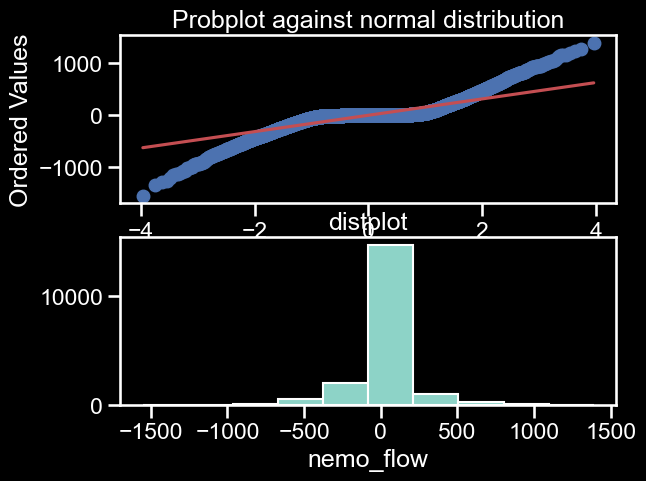

In [81]:
list_features_to_box_cox, list_features_non_box_cox = box_cox_test(df_diff_1)

transform box cox

In [82]:
df_diff_1_transfo, dict_lambda_bc = transfo_boxcox(df_diff_1, list_features_to_box_cox)

## minmaxscaler

In [83]:
df_diff_1_train = df_diff_1_transfo[:-n_period_predict]

In [84]:
#We apply a minmaxscaler transform to the data we could not transform thanks to boxcox
minmaxscaler = MinMaxScaler()
minmaxscaler = minmaxscaler.fit(df_diff_1_train[list_features_non_box_cox])
df_diff_1_transfo[list_features_non_box_cox] = minmaxscaler.transform(df_diff_1_transfo[list_features_non_box_cox])

Everything is now stationary ! We can go on :)

# III. Train

what if the BIC is minimized but the error is not ?

# IV. Predict on test

In [85]:
model_var, train_var, train_var_exog, test_var, test_var_exog, df_diff_itinial_converged, result_normality, result_whiteness = convergence_lag_features(df_diff_1_transfo, exog_pour_var, 7, n_period_predict)

d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


7
7
lag actuel égal 7
Colonnes gardées = Index(['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow'],
      dtype='object')


d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


le lag après l'opti de granger puis reopti model est de 7
Le lag final est de 7
Les features finales sont Index(['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow'],
      dtype='object')


In [86]:
model_var = VAR(endog = train_var, exog = train_var_exog)
model_var = model_var.fit(maxlags = 51, ic = 'aic')

d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [98]:
lag_order = model_var.k_ar
input_data = train_var.values[-lag_order:]
y_predicted = model_var.forecast(y = input_data, steps = len(test_var), exog_future=test_var_exog)

df_predicted = pd.DataFrame(y_predicted, index=test_var.index, columns=train_var.columns)

In [99]:
df_predicted

,nd,tsd,england_wales_demand,embedded_wind_generation,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow
settlement_date,,,,,,,,,,,
2023-01-20 00:00:00,0.463010,0.563711,0.495244,0.555215,0.556650,0.430210,0.481891,0.505635,0.543558,0.577419,0.566474
2023-01-20 00:30:00,0.588152,0.619128,0.508158,0.565742,0.507170,0.444540,0.501370,0.524343,0.545333,0.629633,0.550682
2023-01-20 01:00:00,0.493408,0.583122,0.497823,0.564134,0.568819,0.439510,0.510419,0.503842,0.483541,0.574736,0.554935
2023-01-20 01:30:00,0.457076,0.564033,0.490267,0.552634,0.546210,0.425407,0.480850,0.526985,0.442508,0.556676,0.531269
2023-01-20 02:00:00,0.452738,0.565730,0.492347,0.568028,0.545204,0.423461,0.484335,0.522099,0.470265,0.575623,0.523439
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 21:30:00,0.357248,0.499183,0.479053,0.517829,0.537866,0.426694,0.474122,0.519885,0.494830,0.576959,0.522059
2023-01-26 22:00:00,0.340558,0.497459,0.476883,0.519436,0.552098,0.420040,0.466465,0.507956,0.505545,0.587180,0.513360
2023-01-26 22:30:00,0.347777,0.496869,0.477829,0.519178,0.559805,0.432085,0.480362,0.517017,0.492039,0.574942,0.524402


In [100]:
initial_testing_set = initial_testing_set[df_predicted.columns]
df_diff_1_train = df_diff_1_train[df_predicted.columns]
df_pour_var = df_pour_var[df_predicted.columns]

In [101]:
list_features_non_box_cox = list(set(list_features_non_box_cox) & set(df_predicted.columns))
list_features_to_box_cox = list(set(list_features_to_box_cox) & set(df_predicted.columns))

In [102]:
minmaxscaler= MinMaxScaler()
minmaxscaler = minmaxscaler.fit(df_diff_1_train)
df_predicted[list_features_non_box_cox] = minmaxscaler.inverse_transform(df_predicted[list_features_non_box_cox])
for col in list_features_to_box_cox:
    df_predicted[col]=inv_boxcox(df_predicted[col], dict_lambda_bc[col])

In [103]:
df_predicted

,nd,tsd,england_wales_demand,embedded_wind_generation,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow
settlement_date,,,,,,,,,,,
2023-01-20 00:00:00,-1491.281434,50.968674,-94.992953,70.574232,-23.246191,-24.683302,-260.969415,47.019172,56.497016,36.319198,3649.199703
2023-01-20 00:30:00,-62.658230,95.302678,-57.000299,94.038685,-62.335308,18.063984,-116.864724,93.565488,61.732917,73.965488,2794.259000
2023-01-20 01:00:00,-1144.254656,66.497782,-87.405694,90.455366,-13.633384,3.058637,-49.920212,42.557837,-120.552841,34.384921,3024.524922
2023-01-20 01:30:00,-1559.025432,51.226438,-109.635688,64.820798,-31.493737,-39.011694,-268.670190,100.138766,-241.600591,21.363159,1743.289779
2023-01-20 02:00:00,-1608.546115,52.584272,-103.514795,99.133702,-32.288775,-44.815987,-242.888291,87.981834,-159.717777,35.024436,1319.423234
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 21:30:00,-2698.660108,-0.653560,-142.625761,-12.759271,-38.085770,-35.170640,-318.445724,82.474823,-87.250162,35.987311,1244.722032
2023-01-26 22:00:00,-2889.186378,-2.032960,-149.009083,-9.177098,-26.842971,-55.021658,-375.093777,52.793821,-55.642157,43.356427,773.768895
2023-01-26 22:30:00,-2806.776606,-2.504469,-146.227765,-9.752011,-20.754128,-19.089028,-272.278961,75.337992,-95.485054,34.532866,1371.534865


In [104]:
#de transfo
df_predicted = inv_diff(df_pour_var, df_predicted, n_period_predict)

In [105]:
print(model_var.bic)
print(model_var.k_ar)
mae = mean_absolute_error(initial_testing_set['tsd'], df_predicted['tsd'])
mse = mean_squared_error(initial_testing_set['tsd'], df_predicted['tsd'])
r2_a = r2_ajusted(r2_score(initial_testing_set['tsd'], df_predicted['tsd']), df_predicted)
print(mae)
print(mse)
print(r2_a)

-69.79109394501849
51
10426.993835478825
149936894.14860228
-3.7099039607423947


C:\Users\vdistefano\AppData\Local\Temp\ipykernel_17800\1031854975.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


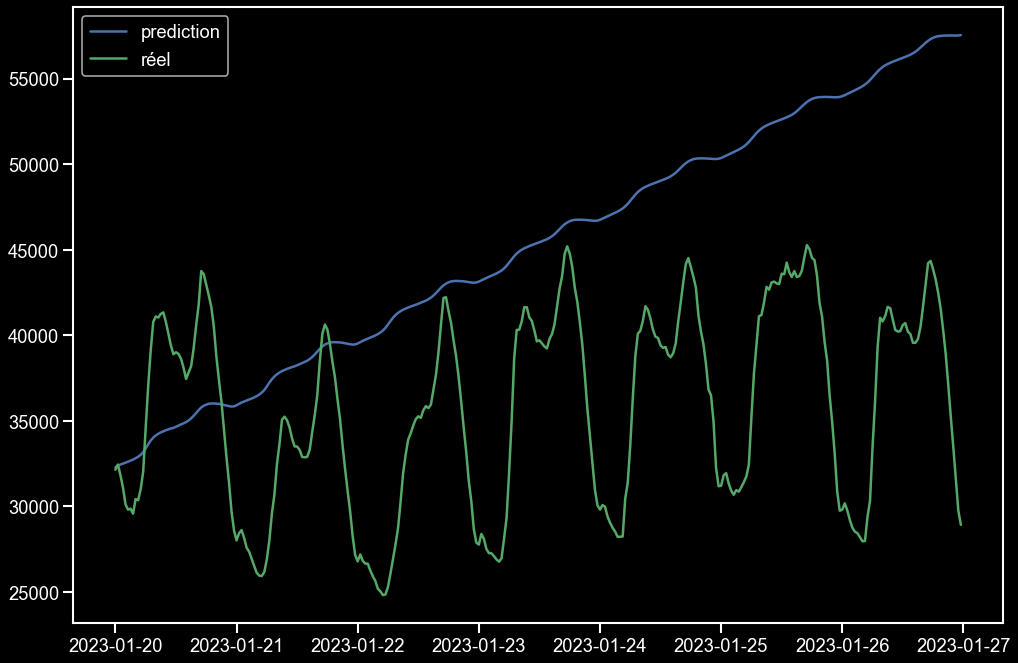

In [106]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
test_pred, = ax.plot(df_predicted.index, df_predicted['tsd'], color = "b")
test_test, = ax.plot(df_predicted.index, initial_testing_set['tsd'], color = "g")
ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
fig.show()

C:\Users\vdistefano\AppData\Local\Temp\ipykernel_17800\462285887.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


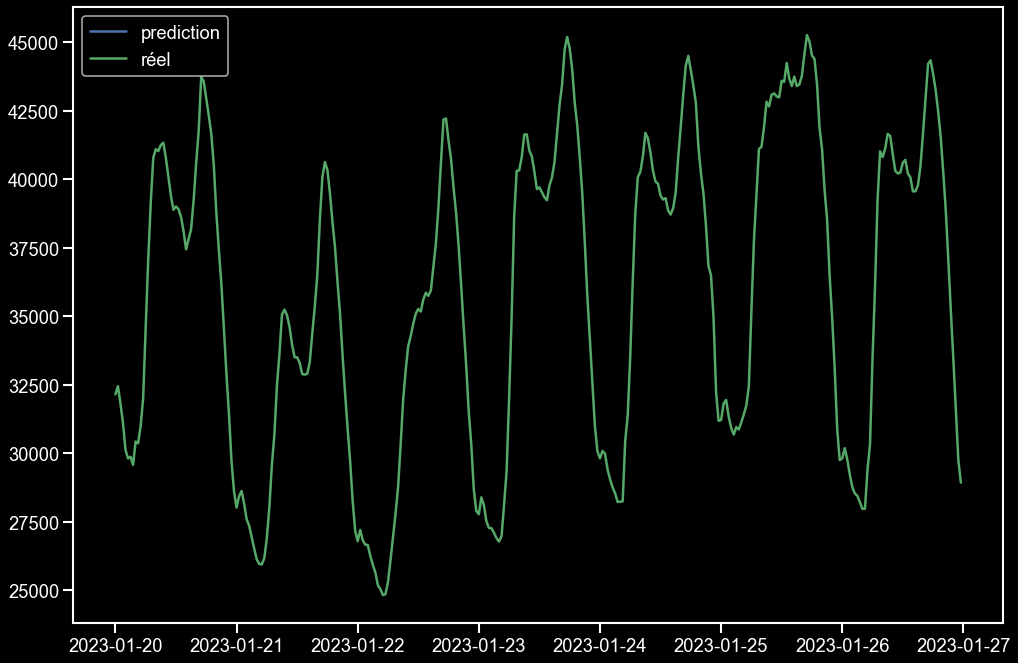

In [48]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
test_test, = ax.plot(df_predicted.index, initial_testing_set['tsd'], color = "g")
ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
fig.show()

lag_order = model_var.k_ar
input_data = train_var.values[-lag_order:]
y_predicted = model_var.forecast(y = input_data, steps = len(test_var))

df_predicted = pd.DataFrame(y_predicted, index=test_var.index, columns=train_var.columns)

# V. De-transformation

df_true_results = inv_diff(df_pour_var, df_predicted, n_period_predict)

MAE_var = mean_absolute_error(df_pour_var[variable_cible.name].iloc[-n_period_predict:], df_true_results[variable_cible.name+'_forecast'])